In [1]:
%matplotlib notebook

#Import Libraries
import tensorflow as tf
import numpy as np
import math
import os
import matplotlib
import matplotlib.pyplot as plt
import datetime
import time

import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils.vis_utils import plot_model

from models import save_model, generator, generate_model, plot_performance

Using TensorFlow backend.


In [2]:
X_load = np.load('../data/fake_data/X.npy')
Y_load = np.load('../data/fake_data/Y.npy')

res = tf.one_hot(Y_load, depth=2)
with tf.Session() as sess:
    Y_load = (sess.run(res))

split_index = int(X_load.shape[0]*0.8)
    
X_train = X_load[:split_index]
Y_train = Y_load[:split_index]
X_val = X_load[split_index:]
Y_val = Y_load[split_index:]

 

In [3]:
batch_size = 1000
n_hidden = 50
n_dim = 1
input_shape = (n_hidden, n_dim)


model = generate_model(input_shape)

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50, 1)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 6)             48        
_________________________________________________________________
average_pooling1d_1 (Average (None, 25, 6)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 25, 12)            516       
_________________________________________________________________
average_pooling1d_2 (Average (None, 12, 12)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 12, 12)            1020      
_________________________________________________________________
average_pooling1d_3 (Average (None, 6, 12)             0         
__________

In [4]:
train_generator = generator(X_train, Y_train, batch_size, n_hidden)
validate_generator = generator(X_val, Y_val, batch_size, n_hidden)

history = model.fit_generator(train_generator,
                              steps_per_epoch=1000,
                              epochs=10, 
                              verbose=1,
                              validation_data=validate_generator,
                              validation_steps=1000,)

save_model(model)

Epoch 1/10
1000/1000 [==============================] - 231s 231ms/step - loss: 0.0789 - acc: 0.9742 - val_loss: 0.0290 - val_acc: 0.9886
Epoch 2/10
1000/1000 [==============================] - 207s 207ms/step - loss: 0.0337 - acc: 0.9870 - val_loss: 0.0293 - val_acc: 0.9883
Epoch 3/10
1000/1000 [==============================] - 201s 201ms/step - loss: 0.0333 - acc: 0.9876 - val_loss: 0.0332 - val_acc: 0.9875
Epoch 4/10
1000/1000 [==============================] - 175s 175ms/step - loss: 0.0432 - acc: 0.9862 - val_loss: 0.0345 - val_acc: 0.9877
Epoch 5/10
1000/1000 [==============================] - 179s 179ms/step - loss: 0.0341 - acc: 0.9876 - val_loss: 0.0432 - val_acc: 0.9858
Epoch 6/10
1000/1000 [==============================] - 112s 112ms/step - loss: 0.0732 - acc: 0.9804 - val_loss: 0.0689 - val_acc: 0.9825
Epoch 7/10
1000/1000 [==============================] - 121s 121ms/step - loss: 0.0627 - acc: 0.9822 - val_loss: 0.0578 - val_acc: 0.9801
Epoch 8/10
1000/1000 [============

<IPython.core.display.Javascript object>


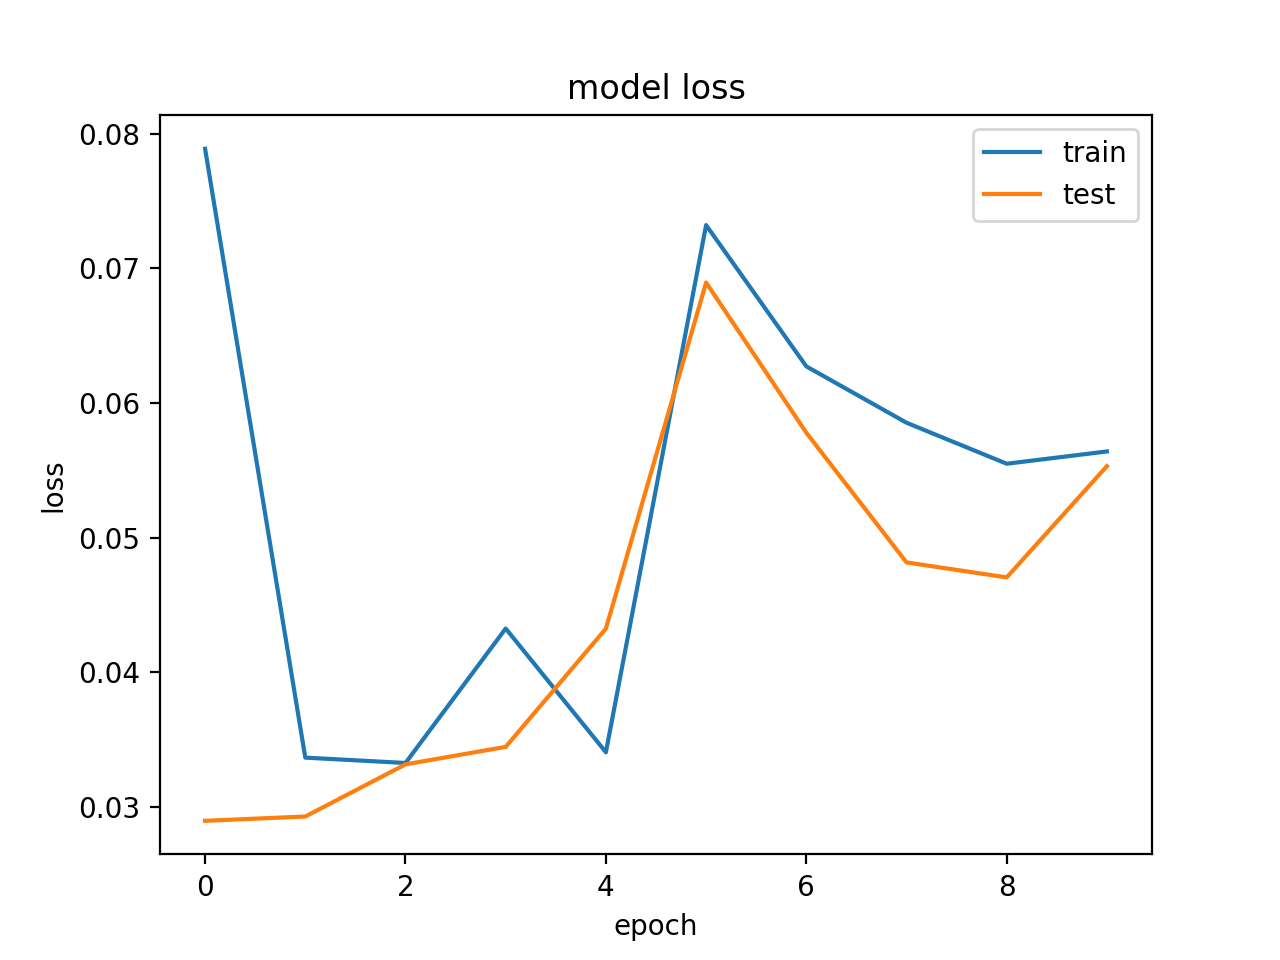

<IPython.core.display.Javascript object>


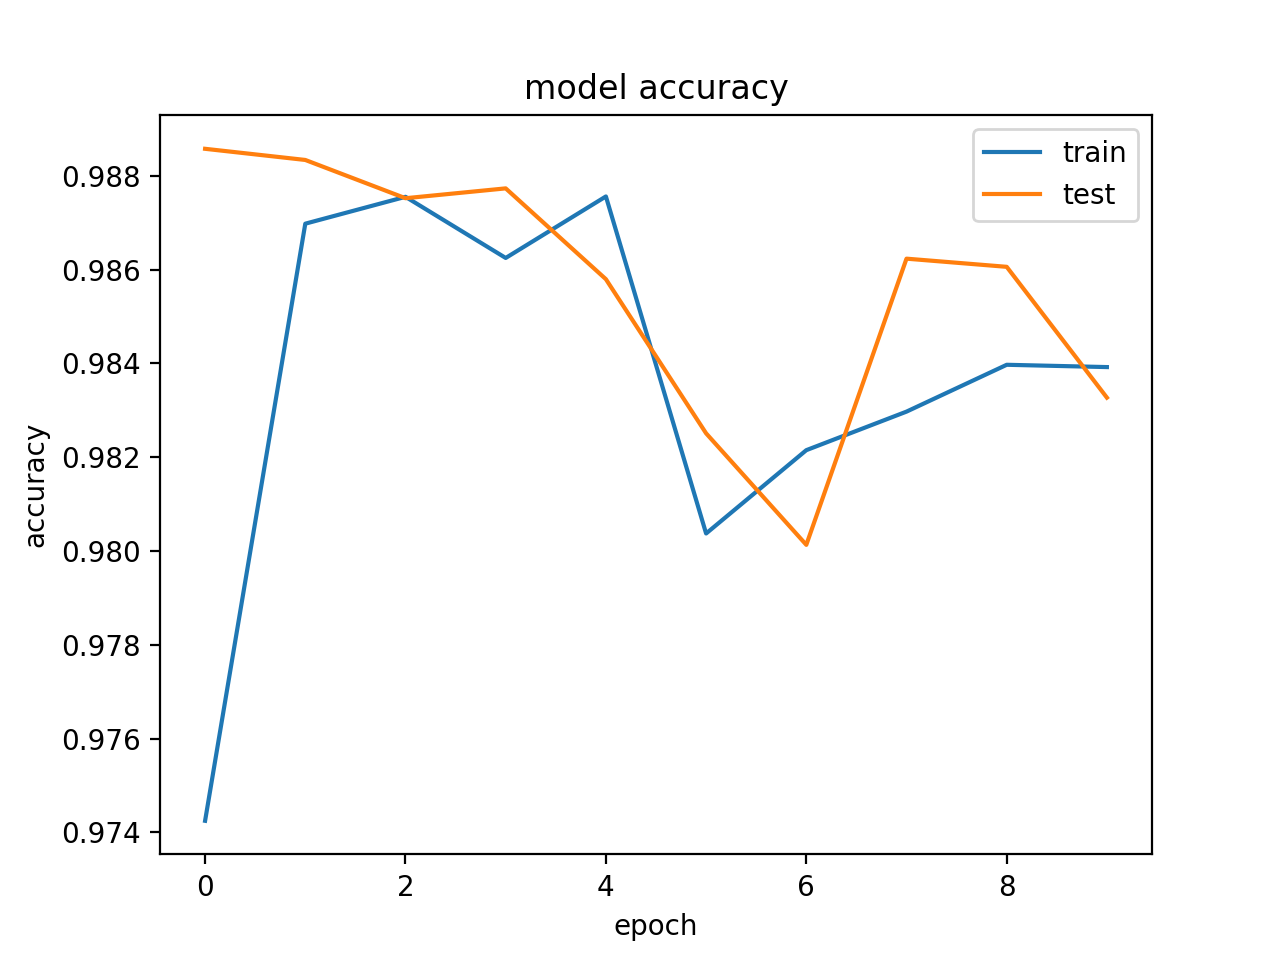

In [5]:
plot_performance(history)

In [6]:
import matplotlib as mpl

def decode(value):
    return np.argmax(value, axis=-1)

def make_accuracy_matrix_plot(model, validate_generator, ref='truth'):
    X_trial, y_trial, = next(validate_generator)
    res = model.predict(X_trial)

    y = decode(y_trial)
    res = decode(res)

    res_matrix = np.zeros((2,2))
    for i, true_label in enumerate(set(y)):
        for j, reco_label in enumerate(set(y)):
            mask_true = y==true_label
            mask_reco = res==reco_label
            if ref=='truth':
                res_matrix[i,j] = np.sum(mask_true*mask_reco) / np.sum(mask_true)
            if ref=='est':
                res_matrix[i,j] = np.sum(mask_true*mask_reco) / np.sum(mask_reco)

    plt.figure()
    im = plt.matshow(res_matrix, norm=mpl.colors.Normalize(vmin=0., vmax=1.))
    for i in range(res_matrix.shape[0]):
        for j in range(res_matrix.shape[0]):
            if res_matrix[i, j]>0.5:
                color = 'k'
            else:
                color = 'w'
            text = plt.text(j, i, np.round(res_matrix[i, j], decimals=3), ha='center', va='center', color=color)
    plt.colorbar(im)
    plt.show()

<IPython.core.display.Javascript object>


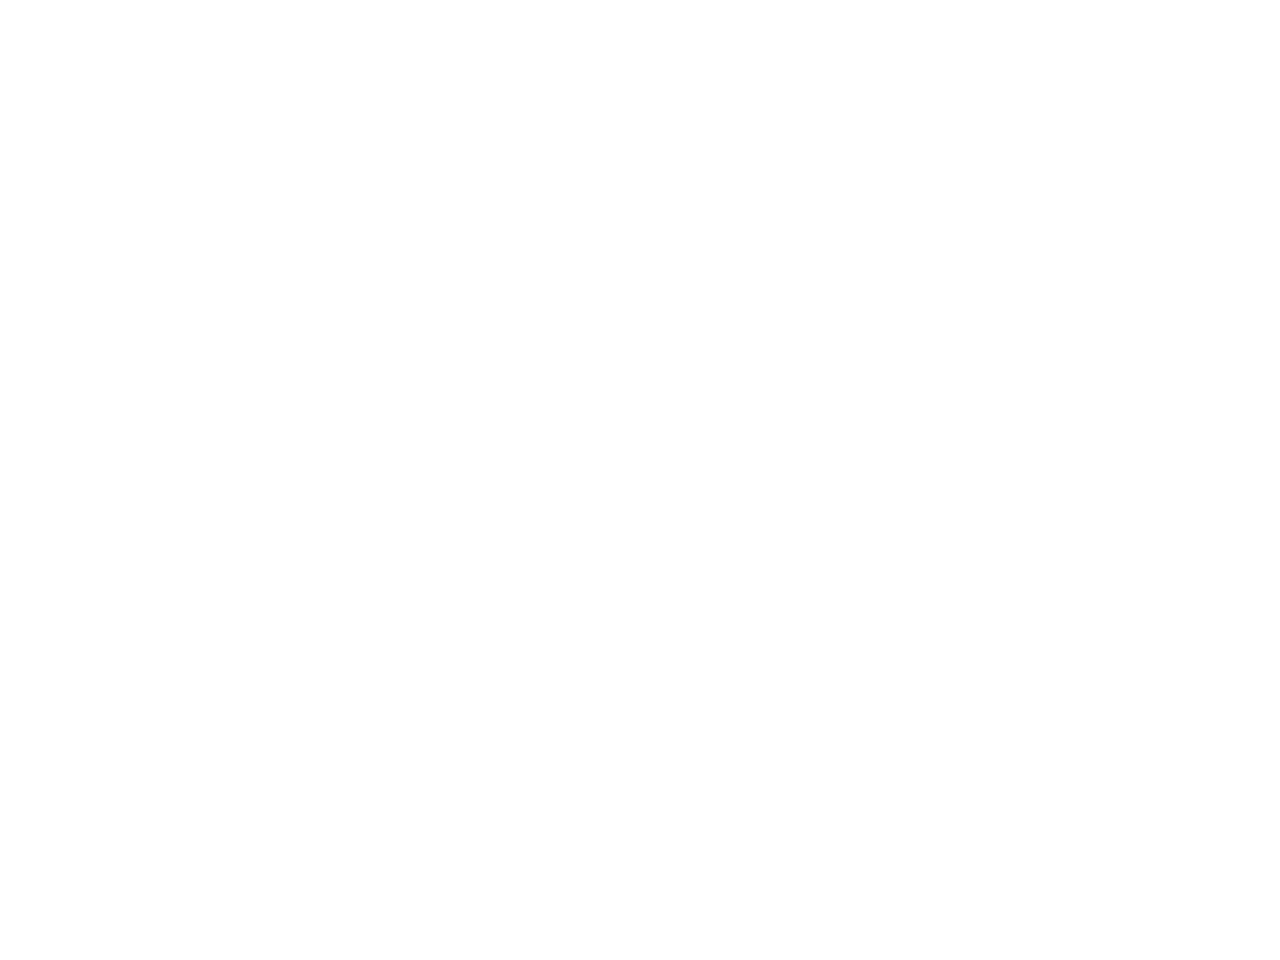

<IPython.core.display.Javascript object>


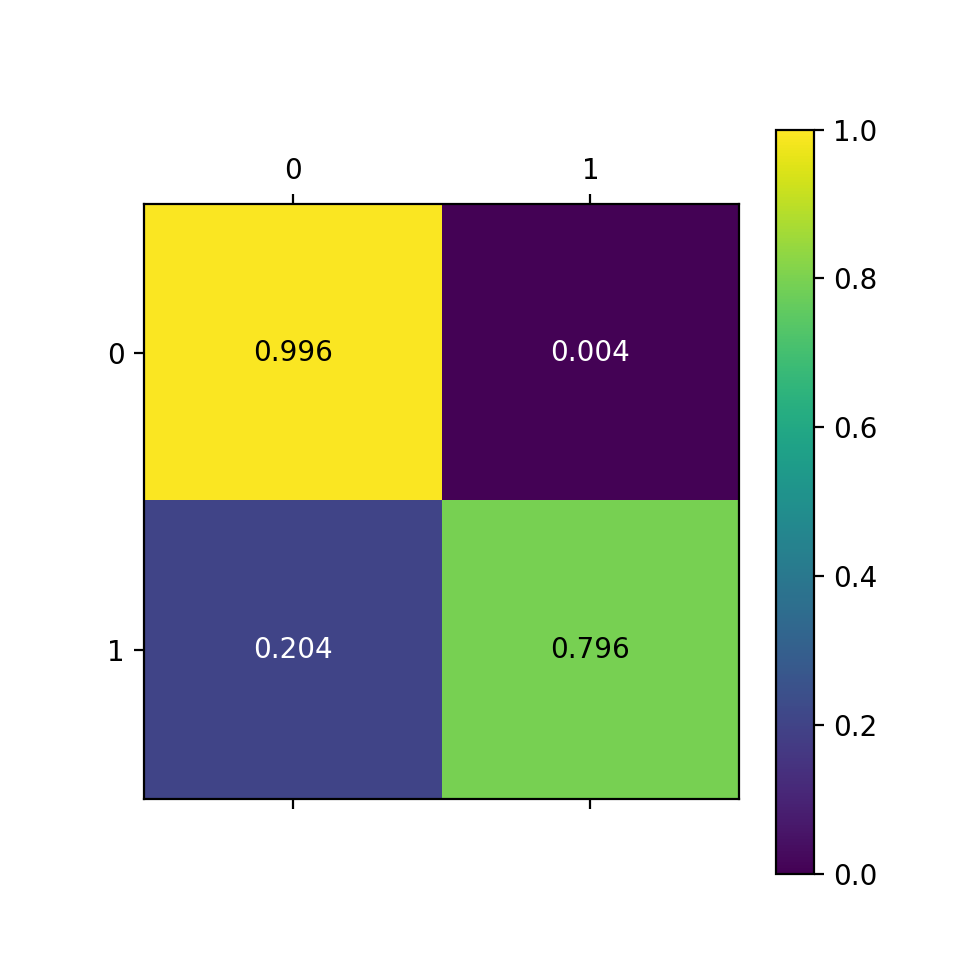

<IPython.core.display.Javascript object>


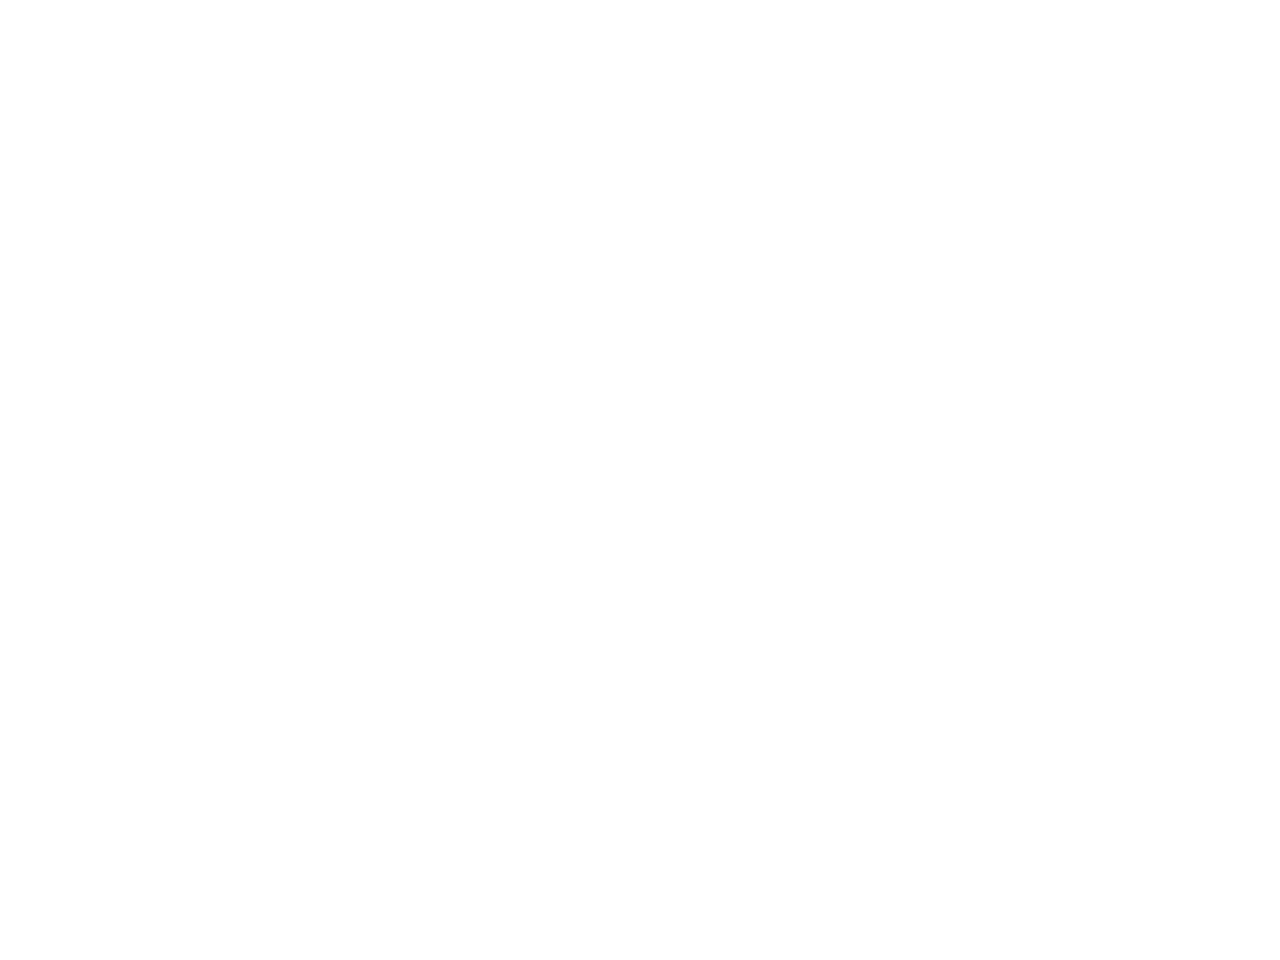

<IPython.core.display.Javascript object>


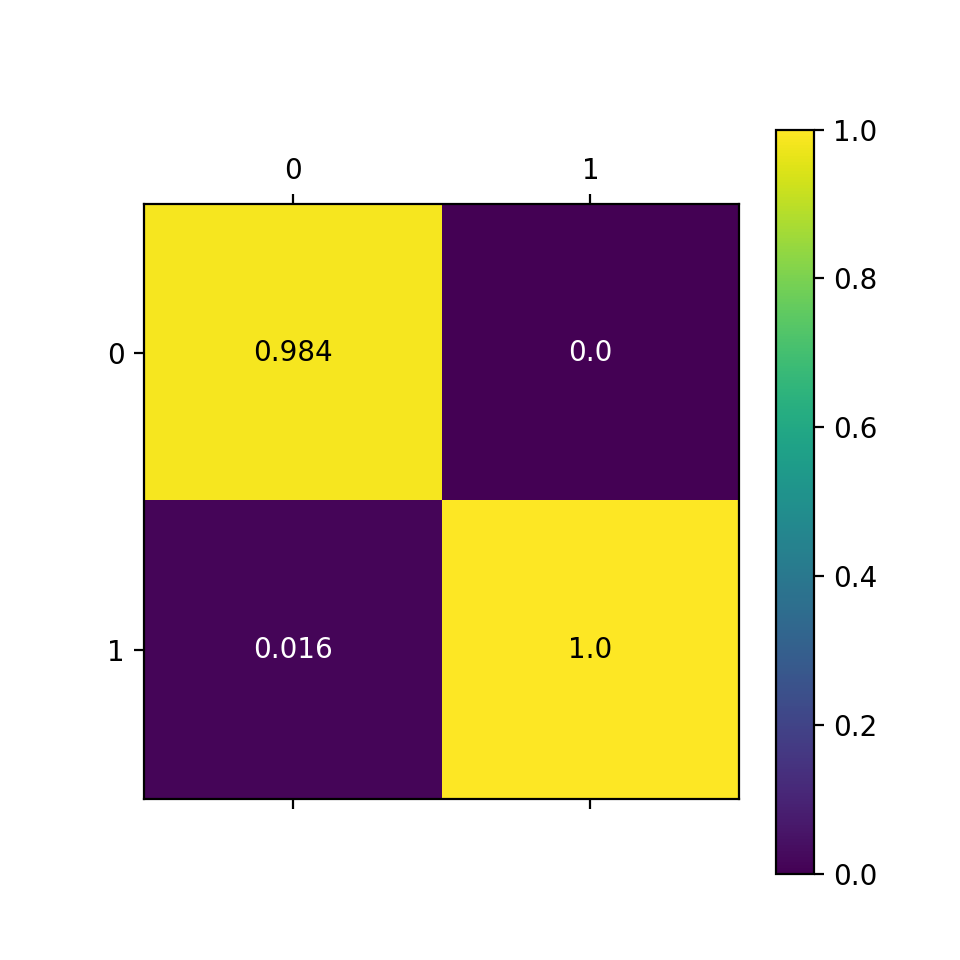

In [7]:
make_accuracy_matrix_plot(model, validate_generator)
make_accuracy_matrix_plot(model, validate_generator, ref='est')


In [8]:
save_dir = 'plots'
if not os.path.exists(save_dir):
        os.makedirs(save_dir)

second_dir = 'simple'
save_dir = os.path.join(save_dir, second_dir)  
if not os.path.exists(save_dir):
        os.makedirs(save_dir)




In [9]:
X = X_val
y = np.argmax(Y_val, axis=1)
t = np.arange(X.shape[0])

n_slices = X.shape[0] - n_hidden

all_y = np.zeros((n_slices, 2))

for i in range(n_slices):
    x_input = np.reshape(X[i:i+n_hidden], (1, n_hidden, 1))
    all_y[i] = model.predict(x_input)
    
y_pred_int = np.argmax(all_y, axis=1)

y_res = np.zeros_like(t)
y_res[int(n_hidden/2):int(-n_hidden/2)] = y_pred_int

<IPython.core.display.Javascript object>


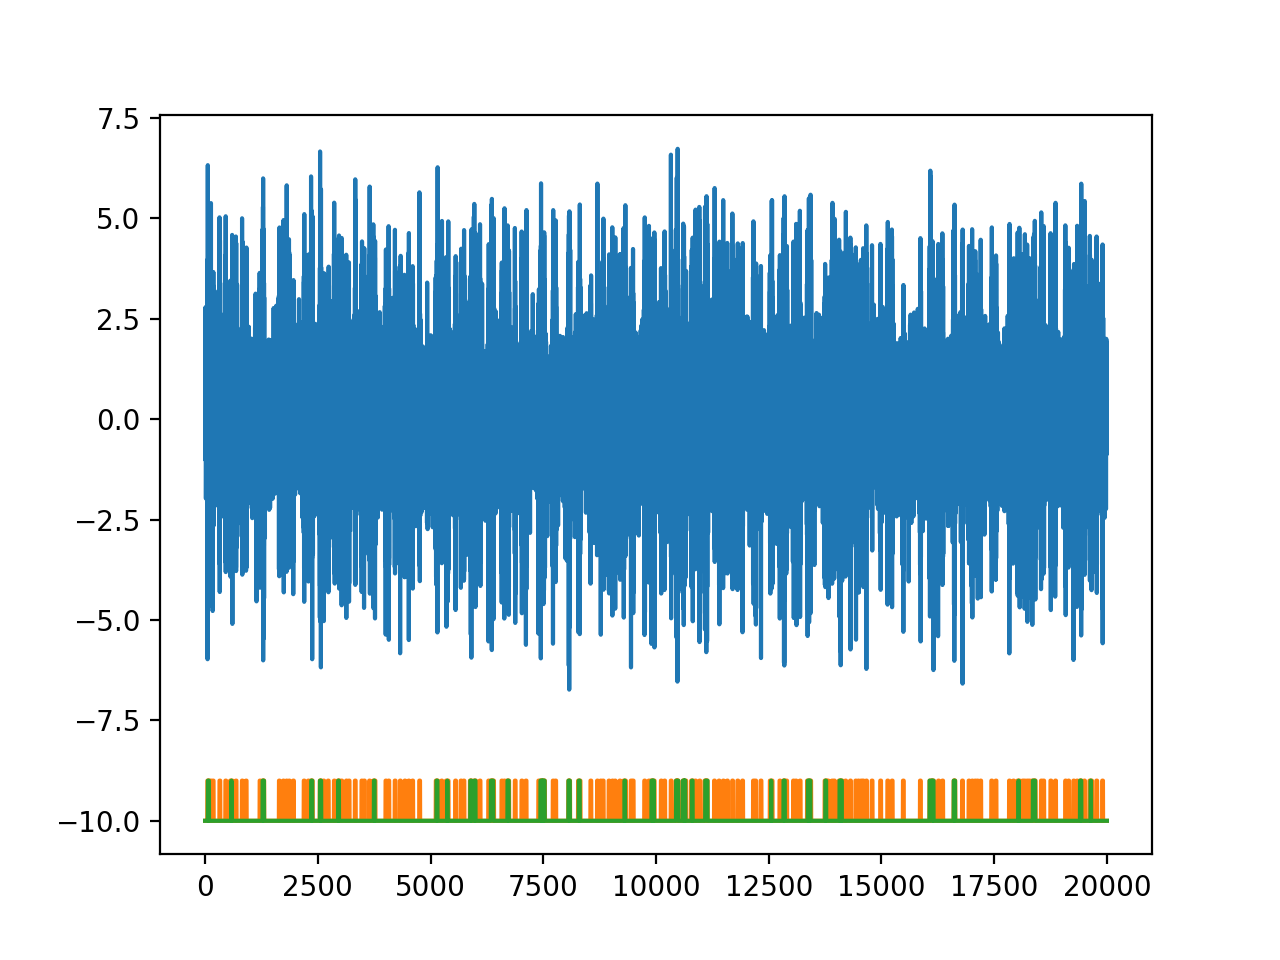

In [10]:
plt.figure()
plt.plot(t, X)
plt.plot(t, y-10, )
plt.plot(t, y_res-10)
# plt.xlim(100, 500)
plt.show()